In [43]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy
from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [44]:
data = np.random.rand(20)

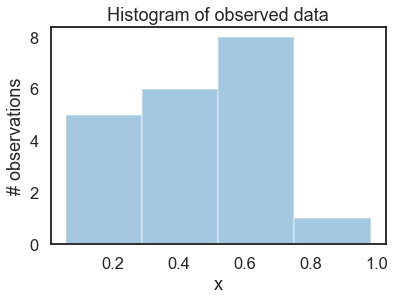

In [45]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data',xlabel='x',ylabel='# observations')

In [46]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    #print(mu_post, sigma_post)
    return sp.stats.norm(mu_post, np.sqrt(sigma_post)).pdf(x)

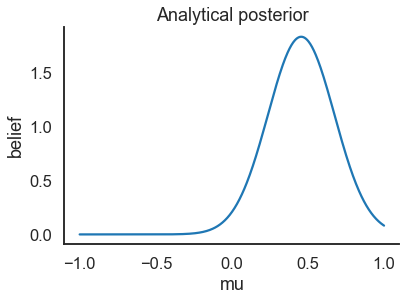

In [47]:
ax = plt.subplot()
x = np.linspace(-1,1,500)
posterior_analytical = calc_posterior_analytical(data,x,0.,1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu',ylabel='belief',title='Analytical posterior')
sns.despine()

In [48]:
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

In [49]:
def sampler(data, samples=4, mu_init=.5,proposal_width=.5,plot=False,
           mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        #suggest new position
        mu_proposal = sp.stats.norm(mu_current, proposal_width).rvs()
        #compute likelihood by multiplying probs of each data point
        likelihood_current = sp.stats.norm(mu_current,1).pdf(data).prod()
        likelihood_proposal = sp.stats.norm(mu_proposal,1).pdf(data).prod()
        
        #compute prior prob of current and proposed mu
        prior_current = sp.stats.norm(mu_prior_mu,mu_prior_sd).pdf(mu_current)
        prior_proposal = sp.stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current*prior_current
        p_proposal = likelihood_proposal*prior_proposal
        
        #Accept proposal?
        p_accept = p_proposal/p_current
        #usually would include prior probability, which we neglect here for simplicity
        
        accept = np.random.rand()<p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior ,i)
        
        if accept:
            mu_current=mu_proposal
        
        posterior.append(mu_current)
    
    return np.array(posterior)

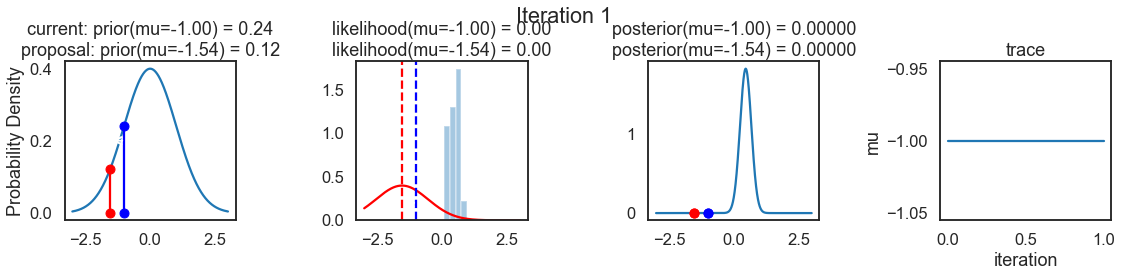

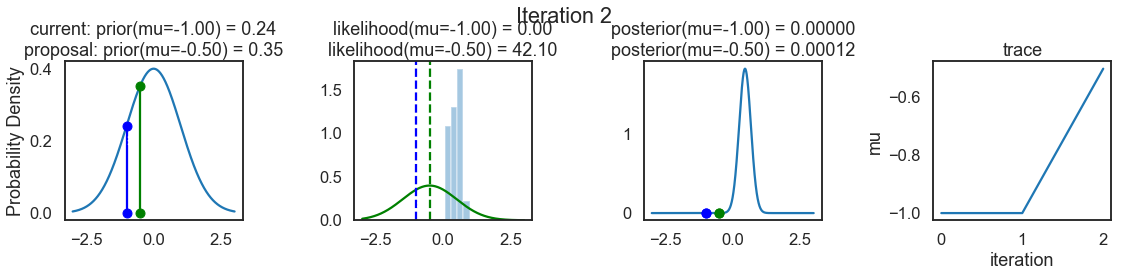

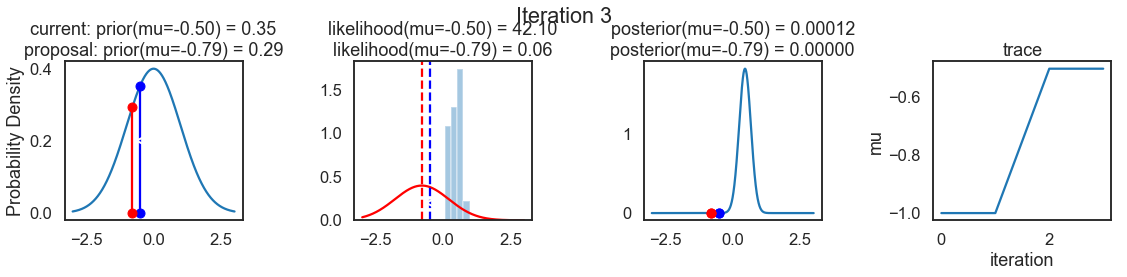

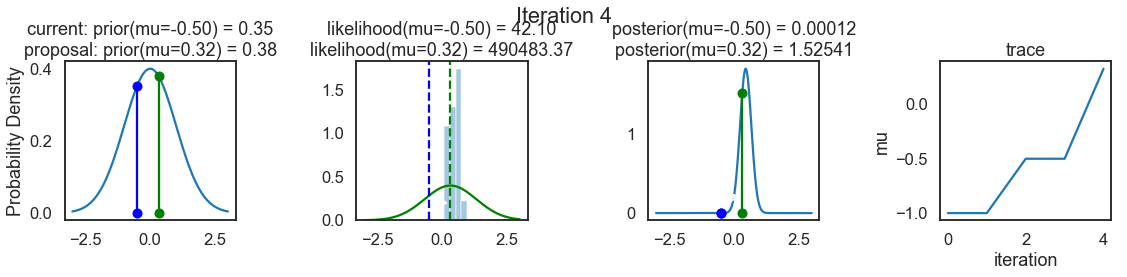

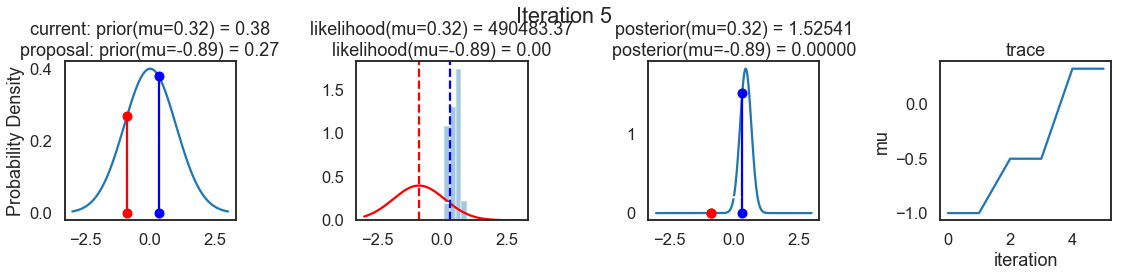

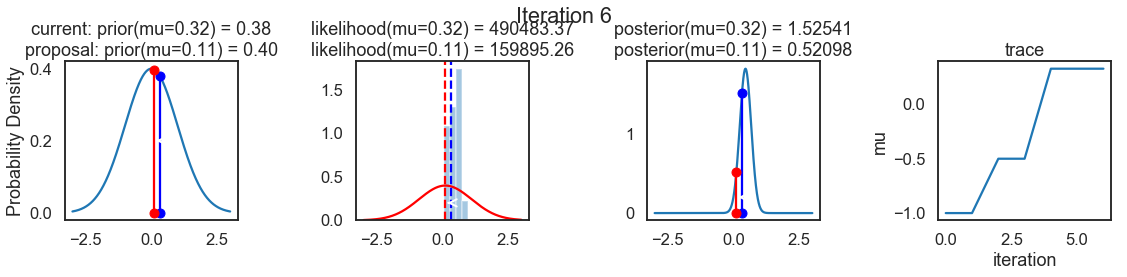

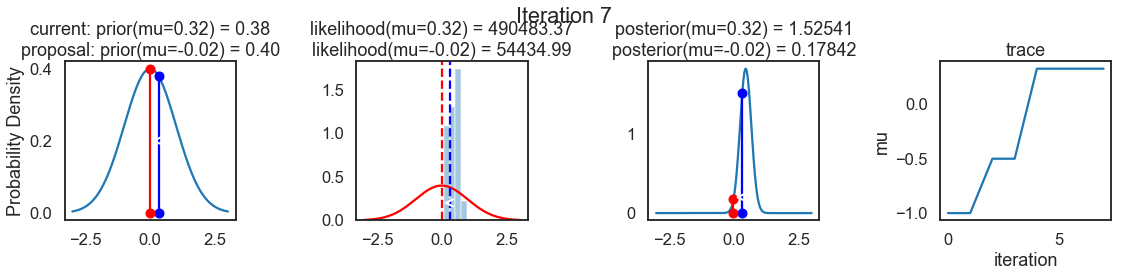

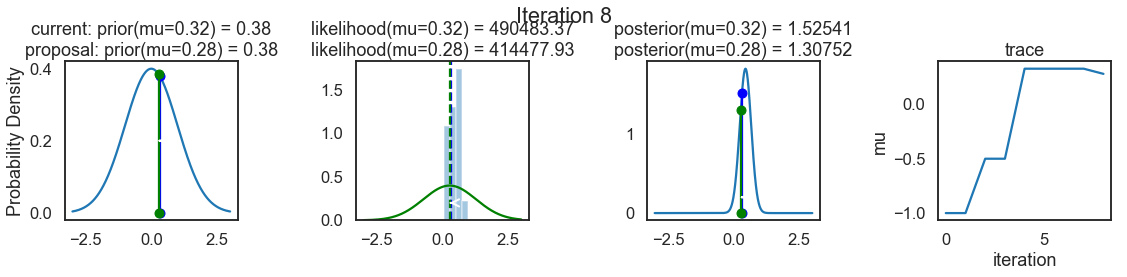

In [52]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

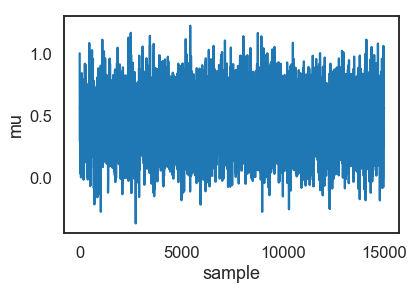

In [53]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

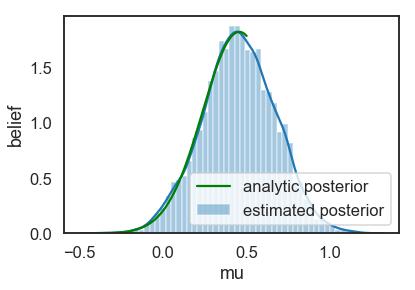

In [54]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

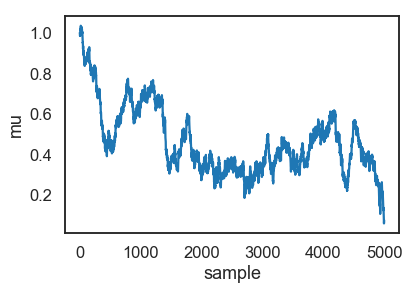

In [55]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

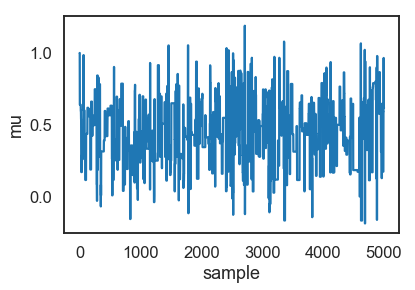

In [56]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

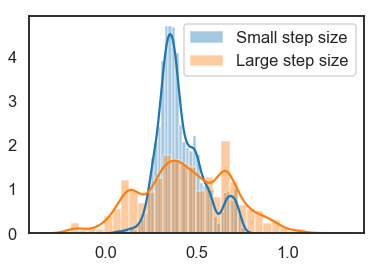

In [57]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


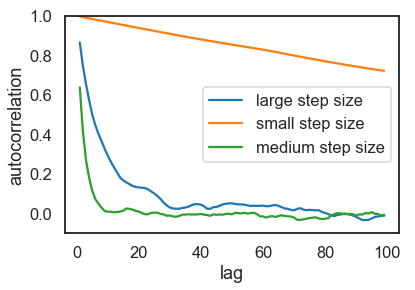

In [60]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 62000/62000 [00:14<00:00, 4234.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


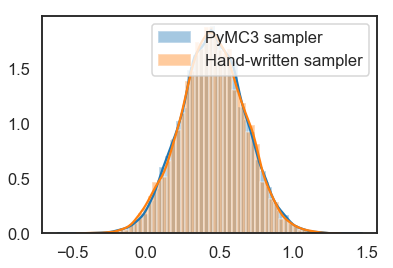

In [61]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu',0,1)
    sigma=1.
    returns=pm.Normal('returns',mu=mu,sd=sigma,observed=data)
    step = pm.Metropolis()
    trace = pm.sample(15000,step)
    
sns.distplot(trace[2000:]['mu'],label='PyMC3 sampler');
sns.distplot(posterior[500:],label='Hand-written sampler');
plt.legend();